## Análisis de los datos obtenidos en el experimento del circuito RLC pasabanda

En este tuto muestro,
- Cómo cargar y explorar los datos del experimento
- Cómo obtener la función de transferencia experimental del filtro y compararla con la función teórica.
- Cómo obtener la curva de atenuación experimental y comparala con la curva teórica.
- Cómo obtener la potencia activa del sistema.
- Cómo determinar el factor de mérito experimental, $Q$, del filtro.

Empezamos importando las librerías que vamos a utilizar,

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Cargo los datos, tengo para dos valores de resistencia distintos $R=50\Omega$ y $R=100\Omega$

In [2]:
arx= 'datos/fpasabanda_R50.csv'

df_R50 = pd.read_csv(arx)

arx= 'datos/fpasabanda_R100.csv'

df_R100 = pd.read_csv(arx)

df_R50.head()

,frec,vin,vout,desfase
0,10.0,5.011070,0.014856,89.981999
1,110.0,5.034323,0.028512,89.801046
2,210.0,5.009134,0.081323,89.615301
3,310.0,5.017071,0.085080,89.420004
4,410.0,5.024290,0.074312,89.209577


Hago un plot exploratorio con los dos conjuntos de datos:

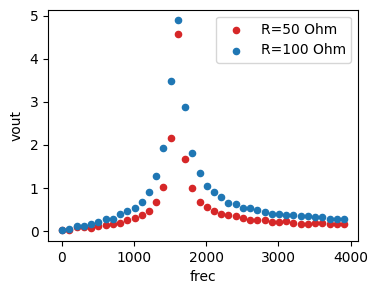

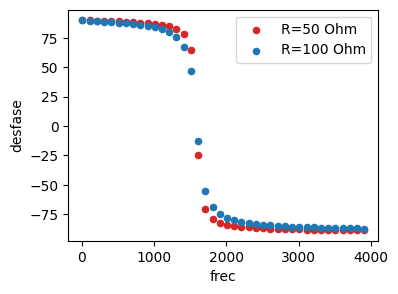

In [3]:
fig,ax = plt.subplots(figsize=(4,3))

df_R50.plot( x='frec', y="vout", ax=ax, kind='scatter', label='R=50 Ohm',color='C3' )

df_R100.plot( x='frec', y="vout", ax=ax , kind='scatter', label='R=100 Ohm')

plt.show()


fig,ax = plt.subplots(figsize=(4,3))

df_R50.plot( x='frec', y="desfase", ax=ax, kind='scatter', label='R=50 Ohm',color='C3' )

df_R100.plot( x='frec', y="desfase", ax=ax , kind='scatter', label='R=100 Ohm')

plt.show()



### Función de transferencia

Obtenemos la función de transferencia experimental del filtro y la comparamos con la curva teórica.

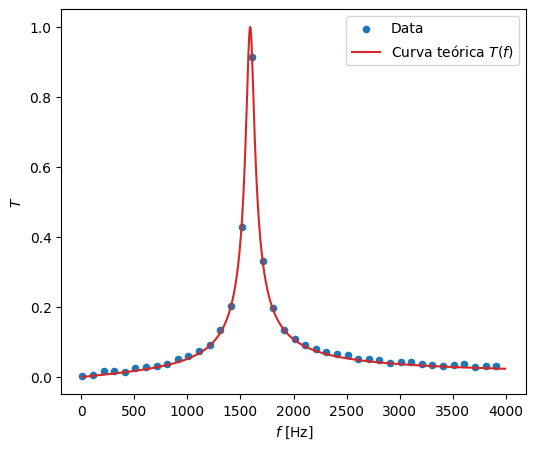

In [4]:
df_R50["T"] = df_R50["vout"]/df_R50["vin"]

R=50
L=100e-3
C=100e-9

X = lambda w: w*L - 1.0/(w*C) 

T = lambda f: 1.0/(np.sqrt( 1+ ( X(2*np.pi*f)/R )**2 ))

f = np.arange( 10,4000,5 )


fig,ax = plt.subplots( figsize=(6,5) )

df_R50.plot( x='frec', y='T', kind='scatter', ax=ax , label='Data')

ax.plot( f, T(f),c='C3' ,label='Curva teórica $T(f)$')

ax.set_xlabel("$f$ [Hz]")
ax.set_ylabel("$T$ ")
plt.legend()
plt.show()

### Atenuación

Obtenemos la Atenuación experimental y la comparamos con la curva teórica.

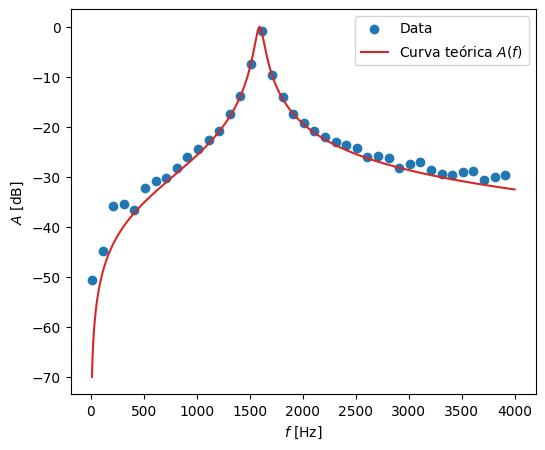

In [5]:
# Atenuacion datos
Td = df_R50["T"].to_numpy()
Ad = 20*np.log10(Td)
fd = df_R50["frec"].to_numpy()


# Atenuacion teorica
R=50
L=100e-3
C=100e-9
f0= (1.0/(2*np.pi))*np.sqrt( 1.0/( L*C ) )

X = lambda w: w*L - 1.0/(w*C) 
T = lambda f: 1.0/(np.sqrt( 1+ ( X(2*np.pi*f)/R )**2 ))
A = lambda f: 20*np.log10( T(f) )
f = np.arange( 10,4000,1 )

# Plot
fig,ax = plt.subplots(figsize=(6,5))

ax.scatter( fd, Ad,c='C0' , label='Data' )

ax.plot( f, A(f), c='C3' ,label='Curva teórica $A(f)$' )

ax.set_xlabel("$f$ [Hz]")
ax.set_ylabel("$A$ [dB]")
plt.legend()
plt.show()




### Potencia

Calculamos y graficamos la potencia disipada en la resistencia (potencia activa).

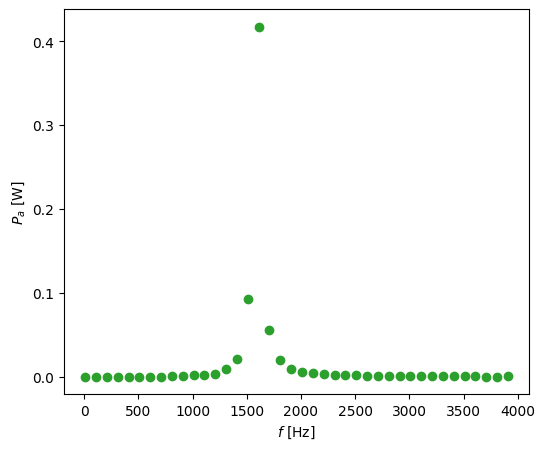

In [6]:
P = np.array( [ v*v for v in df_R50["vout"].to_numpy()] )/R

f = df_R50["frec"].to_numpy()

fig,ax = plt.subplots(figsize=(6,5))

ax.scatter( f, P,c='C2'  )

ax.set_xlabel("$f$ [Hz]")
ax.set_ylabel("$P_a$ [W]")
plt.show()


### Determinación del factor de mérito

Lo hacemos con la atenuación, ya que la curva esta mejor resuelta que la curva de potencia.

Tenemos que determinar del gráfico la frecuencia de resonancia $f_0$.

Tenemos que buscar las frecuencias $f_1$ y $f_2$ cuando $A = -3 dB$

Tomo la curva experimental de la Atenuación:

In [7]:
Td = df_R50["T"].to_numpy()
Ad = 20*np.log10(Td)
fd = df_R50["frec"].to_numpy()

Con el método de bisección busco los puntos experimentales que estan antes y despues de que la curva cruce los $-3dB$. Luego haciendo una interpolación lineal puedo encontrar las frecuencias **$f_1$ y $f_2$** en forma aproximada:

In [8]:
aref = -3           # atenuación de de referencia
i=0

while i<len(fd)-1:

    if Ad[i] < aref and Ad[i+1] > aref:
        l1 = [ [ fd[i+1], Ad[i+1] ], [ fd[i], Ad[i] ] ]

    if Ad[i] > aref and Ad[i+1] < aref:
        l2 = [ [ fd[i], Ad[i] ], [ fd[i+1], Ad[i+1] ] ]
      
    i+=1

# interpolación lineal
a,b = l1
m1 = (b[1]-a[1])/(b[0]-a[0])
o1 = (a[0]*(b[1]-a[1]))/(b[0]-a[0])
f1_a = lambda y : (y+o1)/m1

a,b = l2
m2 = (b[1]-a[1])/(b[0]-a[0])
o2 = (a[0]*(b[1]-a[1]))/(b[0]-a[0])
f2_a = lambda y : (y+o2)/m2

# fecuencias 
f1 = f1_a(aref)
f2 = f2_a(aref)

La **frecuencia de resonancia** experimental la tomo como el máximo de la curva:

In [9]:
imax= np.argmax(Ad)
f0= fd[imax]

Ahora calculo el **Factor de Mérito experimental**:

In [10]:
BWD = f2-f1     # Ancho de banda

print ("\nEstimación de frec resonancia y ancho de banda:")
print ("f0 = %.2f" %f0)
print ("BWD = f2-f1 = %.4f" %BWD)

Qexp= f0/BWD
print ("\nFactor de mérito experimental: ")
print ("Qexp = f0/BWD = %.3f" %(Qexp) )



Estimación de frec resonancia y ancho de banda:
f0 = 1610.00
BWD = f2-f1 = 79.7056

Factor de mérito experimental: 
Qexp = f0/BWD = 20.199


Para el calculo del error uso una aproximación conservadora. Estimo el error de $f_0$, como la 1/2 el ancho de banda a $-3dB$, y el de $f_1$ y $f_2$ como 1/4. Con esta aproximación, propagando el error se tiene:

In [11]:
# Estimación del error
er_f0 = BWD/2.
er_f1 = BWD/4.
er_f2 = BWD/4.

# propagación
er_Qexp = (Qexp/BWD)*np.sqrt( (er_f1)**2 + (er_f2)**2 + (er_f0/Qexp)**2  ) 

print ("Fáctor de merito experimental con error (conservador) :")
print ("Qexp = ( %.2f ± %.2f )" %(Qexp,er_Qexp) )

# Comparo con Q teórico
print ("\nFactor de mérito teórico: ")
R=50
L=100e-3
C=100e-9
f0_th= (1.0/(2*np.pi))*np.sqrt( 1.0/( L*C ) )
print ("Q_th = 2pi f0 L/R = %.3f" %(2*np.pi*f0_th*L/R) )

Fáctor de merito experimental con error (conservador) :
Qexp = ( 20.20 ± 7.16 )

Factor de mérito teórico: 
Q_th = 2pi f0 L/R = 20.000


Vemos que el valor obtenido es muy parecido al teórico. Ahora grafico para mostrar todos los parámetros en juego:

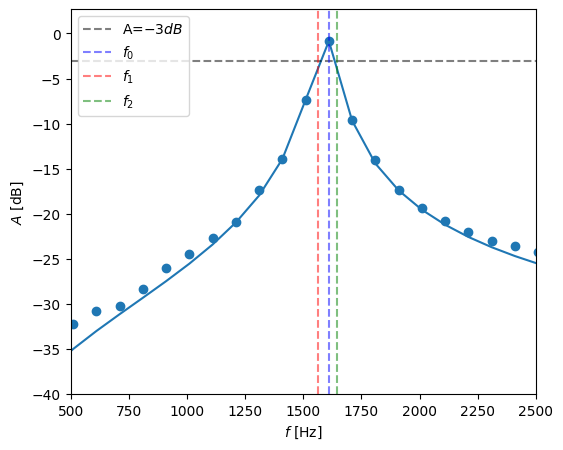

In [12]:
fig,ax = plt.subplots(figsize=(6,5))

ax.scatter( fd, Ad,c='C0'  )

ax.plot( f, A(f),c='C0'  )

ax.axhline( -3, linestyle='--', c='black',alpha=0.5, label="A=$-3dB$" )

ax.axvline( f0, linestyle='--', c='blue',alpha=0.5, label='$f_0$' )

ax.axvline( f1, linestyle='--', c='red'  ,alpha=0.5, label='$f_1$' )

ax.axvline( f2, linestyle='--', c='green',alpha=0.5, label='$f_2$' )

ax.set_ylim(-40,None)
ax.set_xlim(500,2500)
ax.set_xlabel("$f$ [Hz]")
ax.set_ylabel("$A$ [dB]")
plt.legend(loc=2)
plt.show()



### Linearización de la función de transferencia

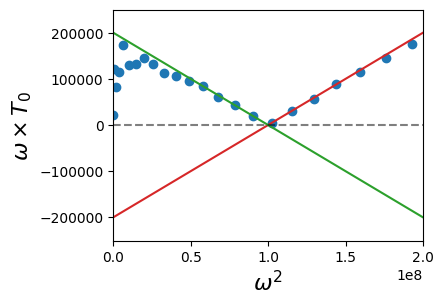

In [36]:
f1 = df_R50["frec"].to_numpy()
T1 = df_R50["T"].to_numpy()

T0 = [   np.sqrt( (1/(t**2)) -1 ) for t in T1]

w = 2*np.pi*f
w2 = w**2

Y = w*T0
X = w2

R=50
L=100e-3
C=100e-9
w02= 1.0/( L*C ) 
m = L/R
b = 1/(R*C)

fl1 = lambda x: x*m - b 
fl2 = lambda x:-x*m + b 


fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( X, Y, c='C0'  )

ax.plot( X, fl1(X), c='C3'  )

ax.plot( X, fl2(X), c='C2'  )

ax.axhline(0, c='black', linestyle='--', alpha=0.5)

ax.set_xlabel(r"$\omega^2$", fontsize=16)
ax.set_ylabel(r"$\omega \times T_0$", fontsize=16)
ax.set_ylim(-0.25e6, 0.25e6 )
ax.set_xlim(0, 2e8 )

plt.show()

In [ ]:



print (w02, m, b)

100000000.0 0.002 200000.00000000003
